In [1]:
import os
import csv
import numpy as np
import pandas as pd
import string
os.environ["KERAS_BACKEND"] = "theano"
import re
import json
import keras
import keras.preprocessing.text as kpt
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.utils.extmath import density
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
import warnings; warnings.simplefilter('ignore')
from sklearn.linear_model import Perceptron


Using Theano backend.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### Global vars

In [2]:
emoticons = r"""
        (?:
            [:=;] # 
            [oO\-]? # 
            [D\)\]\(\]/\\OpP] # 
        )"""
regex = [emoticons,
        r'<[^>]+>',  # HTML
        r'(?:@[\w_]+)',  # @ mentions
        r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URL
        r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash tags
        r'(?:[\w_]+)',  # other words
        r'(?:\S)'  # anything else
        ]
emoticonRegex = re.compile(r'^' + emoticons + '$', re.VERBOSE | re.IGNORECASE)
tokens_re = re.compile(r'(' + '|'.join(regex) + ')', re.VERBOSE | re.IGNORECASE)
stopWords = set(stopwords.words('english') + list(string.punctuation) + list("__"))
stopWords.add('__')
stopWords.add('0084b4')
stopWords.add('c0deed')
stopWords.add('ffffff')
stopWords.add('love')
stopWords.add('like')
stopWords.add('one')
stopWords.add('get')
stopWords.add('life')
stopWords.add('day')
stopWords.add('people')
stopWords.add('go')
stopWords.add('time')
stopWords.add('know')
stopWords.add('new')
stopWords.add('im')
stopWords.add('want')
stopWords.add('good')
stopWords.add('make')
stopWords.add('eeeeee')
stopWords.add('got')
stopWords.add('amp')
stopWords.add('need')
stopWords.add('best')

# Question 1: test pre-processing and data exploration


In [3]:
#read the tweets file
df = pd.read_csv('../input/genderclassifierdfe791531csv/gender-classifier-DFE-791531.csv', encoding = "ISO-8859-1")

#Get only the rows with the genders
data = df.loc[df['gender'].isin(['female', 'male'])]

#if one of the coloums 'text' or 'description' is missing, concatinate it as a dot
data.loc[df['text'].isnull(),'text'] = " "
data.loc[df['description'].isnull(),'description'] = " "
data = data[ data['gender:confidence'] > 0.5 ]

#list of all final processind data witch includes text, description, link_color and sidebar_color columns in a one string.
tweets = data["text"].map(str) + " "+ data["description"]+" "+ data["link_color"]+ " "+data["sidebar_color"]

#processed tweets with gender classification each
tweetsWithGender = pd.DataFrame({'tweets': tweets, 'gender': data["gender"]}, columns=['tweets', 'gender'])


In [4]:
# tokenization function that gets one tweet each time
def tokenization(tweet):
    tweet = re.sub(r'[^\x00-\x7f]*', r'', tweet)
    tokens = tokens_re.findall(tweet)
    tokens = [token if emoticonRegex.search(token) else token.lower() for token in tokens]
    ##empty array to be filled with clean tweets
    tweetTokens = [] 
    for token in tokens:
        if token not in stopWords and not token.isdigit() and len(token) > 1:
            tweetTokens.append(token)
    return tweetTokens

In [5]:
# tokenized tweets array
tweetsNew = []
for i in tweets:
    tweetsNew.append(tokenization(i))

# tokenized tweets with gender 
tweetsNewWithGender = []
for index, row in tweetsWithGender.iterrows():
    tweetsNewWithGender.append([tokenization(row['tweets']),row['gender']])
    
# tweets texts 
TextTweetsNew =[]
for tokenized_text in tweetsNew:
    text = ""
    for token in tokenized_text:
        text += token + " "
    TextTweetsNew.append(text)

# tweets texts with gender 
TextTweetsNewWithGender = []
for tweetAndGender in tweetsNewWithGender:
    text = ""
    gender =tweetAndGender[1] 
    for token in tweetAndGender[0]:
        text += token + " "        
    TextTweetsNewWithGender.append([text,gender])

processedTweets = pd.DataFrame(TextTweetsNewWithGender, columns=['text', 'gender'])




## data exploration

**we would liketo  explorate the data by count the amount of each alsifications - female and male (excluding brand and unknown classifications).  Than, we will check the 10 most common word for each gender **

> ### class distribution:

we would like to explore the

female    6540
male      5954
Name: gender, dtype: int64


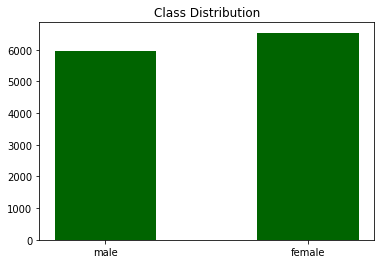

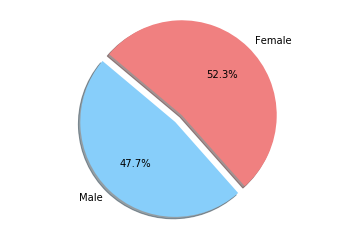

In [6]:

#Exploration
counter = Counter(data["gender"])

print(data["gender"].value_counts())

#Class Distribution:
names = counter.keys()
tweetNum = counter.values()

# Plot histogram
rowsNum = np.arange(len(names))
plt.bar(rowsNum, tweetNum, 0.5, color='darkgreen')
plt.title('Class Distribution')
plt.xticks(rowsNum, names)

#class distribution plot
plt.show()

# Data to plot
labels = 'Male', 'Female'
sizes = [list(tweetNum)[0],list(tweetNum)[1] ]
colors = [ 'lightskyblue', 'lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()



In [7]:
def TopWords(tweetsNew):
    counter = Counter()
    topwords = []
    for tweet in tweetsNew:
        for token in tokenization(tweet):
            topwords.append(token)
    counter.update(topwords)
    return counter.most_common(10)

## terms frequency for the different genders:

In [8]:
print ("Top 10 words befor tokenization: \n")
print ("Top 10 words of Male:")
maleTweets = data.loc[data['gender']== 'male']['text']
print (TopWords(maleTweets))
print('\n')
print ("Top 10 words of Female:")
femaleTweets = data.loc[data['gender']=='female']['text']
print (TopWords(femaleTweets))


Top 10 words befor tokenization: 

Top 10 words of Male:
[('see', 164), ('back', 156), ('think', 156), ('would', 141), ('still', 137), ('last', 131), ('really', 116), ('way', 113), ('great', 112), ('lol', 111)]


Top 10 words of Female:
[('last', 175), ('back', 169), ('still', 160), ('___', 158), ('see', 157), ('today', 138), ('makes', 133), ('really', 132), ('think', 131), ('even', 130)]


In [9]:
print ("Top 10 words after tokenization: \n")

# male top words after tokenizing
print ("Top 10 words of Male 2:")
maleTweets2 = processedTweets.loc[df['gender']== 'male']['text']
print (TopWords(maleTweets2))
print('\n')

# female top words after tokenizing
print ("Top 10 words of Female 2:")
femaleTweets2 = processedTweets.loc[processedTweets['gender']=='female']['text']
print (TopWords(femaleTweets2))


Top 10 words after tokenization: 

Top 10 words of Male 2:
[('world', 139), ('music', 126), ('3b94d9', 125), ('back', 121), ('fan', 118), ('work', 117), ('still', 116), ('f5abb5', 114), ('see', 111), ('follow', 110)]


Top 10 words of Female 2:
[('f5abb5', 278), ('girl', 278), ('9266cc', 275), ('world', 234), ('still', 210), ('back', 205), ('see', 197), ('always', 196), ('follow', 196), ('last', 187)]


# Question 2: Train a machine learning model

In [10]:
Tfidf_vectorizer = TfidfVectorizer()


#creating train and test sets. The test size will be 0.2% of the data.
X_train, X_test, y_train, y_test = train_test_split(TextTweetsNew,data["gender"], test_size=0.20, shuffle = True)


**first, we will train the machine learning models: SVM, Naive Bayes. for each one of them, we try two feature exptraction methods: TF-IDF and Bag of Words. also, we will tune the parameters of the machine learning models and evencualy choose the best classifier and feature extraction method. the best combination will be the one with the best accurecy.**

In [11]:
def calcModels():
    bestAccuracy = 0.0
    for clf, clf_name in ((SGDClassifier(),"SVM"), (MultinomialNB(),"Naive Bayes")):
        print('=' * 80)
        print(clf_name)
        for fe ,fe_name in ((TfidfVectorizer(), "TF-IDF"), (CountVectorizer(),"Bag of Words")):
            print('-' * 80)
            print(fe_name)
            parameters =  {'vect__max_df': (0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0),'clf__alpha': (0.00001,0.0001,0.001,0.01,0.1,1.0)}
            nb_clf =Pipeline([('vect',fe ), ('clf',clf )])
            gs_clf = GridSearchCV(nb_clf, parameters, n_jobs=1)
            gs_clf = gs_clf.fit(X_train, y_train.tolist())
            prediction = gs_clf.predict(X_test)
            accuracy = metrics.accuracy_score(y_test.tolist(), prediction)
            print('accuracy:', accuracy)
            print('Best score: ',gs_clf.best_score_)
            print('Best params: ',gs_clf.best_params_)

            if accuracy > bestAccuracy:
                    bestAccuracy = accuracy
                    bestFeature = fe_name
                    bestCLF = clf_name
                    bestParams= gs_clf.best_params_
    
   
    print("")
    print(":best results")
    print("feature extraction method-",bestFeature)
    print("classifier-",bestCLF)
    print("accurecy-",bestAccuracy)

In [12]:
calcModels()

SVM
--------------------------------------------------------------------------------
TF-IDF
accuracy: 0.6922769107643058
Best score:  0.6648324162081041
Best params:  {'clf__alpha': 0.0001, 'vect__max_df': 0.6}
--------------------------------------------------------------------------------
Bag of Words
accuracy: 0.6758703481392557
Best score:  0.6667333666833417
Best params:  {'clf__alpha': 0.01, 'vect__max_df': 0.9}
Naive Bayes
--------------------------------------------------------------------------------
TF-IDF
accuracy: 0.6978791516606643
Best score:  0.6753376688344173
Best params:  {'clf__alpha': 1.0, 'vect__max_df': 0.3}
--------------------------------------------------------------------------------
Bag of Words
accuracy: 0.6958783513405362
Best score:  0.6782391195597799
Best params:  {'clf__alpha': 1.0, 'vect__max_df': 0.3}

:best results
feature extraction method- TF-IDF
classifier- Naive Bayes
accurecy- 0.6978791516606643


**according to the results of the  tests above, the best machine learning model antil no, is SVM with feature exrtuction of TFIDF **

__ in the second step, we will train a deep learning machine learning model: ANN. the ANN network includs 1 input layer, 2 hedden layers and an output layer. also, we will use 'Dropout' to improve the network.
fwe chose to vectorize the tweets with Tfidf and keep the top 5000 words in a dictionary in order to present every word. then, we will converts each word from string to number. finaly, all weets will be kept in a matrix, each one as a one-hot vector __

In [13]:
# only work with the 3000 most popular words found in our dataset

# tokenizing and creating a dictionary
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(TextTweetsNew)
dictionary = tokenizer.word_index


In [14]:

wordsList = []
wordsListTest = []

for text in X_train:
    wordIndices = [dictionary[word] for word in kpt.text_to_word_sequence(text)]
    wordsList.append(wordIndices)
    
for text in X_test:
    wordIndices = [dictionary[word] for word in kpt.text_to_word_sequence(text)]
    wordsListTest.append(wordIndices)
    
wordsList = np.asarray(wordsList)
wordsListTest = np.asarray(wordsListTest)

In [15]:
# convert tweets to one-hot presentation
XTrainVec = tokenizer.sequences_to_matrix(wordsList, mode='binary')
XTestVec =  tokenizer.sequences_to_matrix(wordsListTest, mode='binary')

lb_make = LabelEncoder()

YTrainNums = lb_make.fit_transform(y_train)
YTestNums = lb_make.fit_transform(y_test)
YTrainVec = keras.utils.to_categorical(YTrainNums, 2)
YTestVec = keras.utils.to_categorical(YTestNums, 2)

In [16]:
#ANN
model = Sequential()
#Input layer + Fully Connected Hidden layer
model.add(Dense(512, input_shape=(5000,), activation='sigmoid', name='dense_1'))
#Using Dropout to avoid overfitting
model.add(Dropout(0.5))
#Fully Connected Hidden layer
model.add(Dense(256, activation='sigmoid', name='dense_2'))
#Using Dropout to avoid overfitting
model.add(Dropout(0.5))
#Output layer
model.add(Dense(2, activation='softmax', name='dense_3'))

In [17]:
model.compile(loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy'])

In [18]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               2560512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 2,692,354
Trainable params: 2,692,354
Non-trainable params: 0
_________________________________________________________________
None


In [19]:
model.fit(XTrainVec, YTrainVec,
  batch_size=128,
  epochs=5,
  verbose=1,
  validation_data=(XTestVec,YTestVec),
  shuffle=True)

Train on 9995 samples, validate on 2499 samples
Epoch 1/5
9995/9995 [==============================] - 5s 492us/step - loss: 0.7825 - acc: 0.5039 - val_loss: 0.6843 - val_acc: 0.6246
Epoch 2/5
9995/9995 [==============================] - 5s 520us/step - loss: 0.6932 - acc: 0.5426 - val_loss: 0.6729 - val_acc: 0.6651
Epoch 3/5
9995/9995 [==============================] - 5s 528us/step - loss: 0.6649 - acc: 0.5969 - val_loss: 0.6419 - val_acc: 0.6747
Epoch 4/5
9995/9995 [==============================] - 5s 523us/step - loss: 0.6322 - acc: 0.6368 - val_loss: 0.6063 - val_acc: 0.6847
Epoch 5/5
9995/9995 [==============================] - 5s 524us/step - loss: 0.5831 - acc: 0.6840 - val_loss: 0.5881 - val_acc: 0.6839


In [20]:
# After the network had been trained. we check the Test Set to see how much acc we get.


scores = model.evaluate(XTestVec, YTestVec)
print("test Accuracy: %.2f%%" % (scores[1]*100))


2499/2499 [==============================] - 1s 254us/step
test Accuracy: 68.39%


__test accuracy - 68.51%__

__the train accuracy is 0.89, as it writen in the last output (that represent the last layer),  at the 'acc' variable.   __

# Question 3: Twitter streaming API

In [21]:
import tweepy
from tweepy import OAuthHandler

accessToken = '1087294304647897088-j73CJ30CTHpzn3G9rdHCpfcOZrKwVQ'
accessSecret = 'YO44ugYSDIPFDDHG6DSD0DI3U2XEBDY5GaeOXzcaPRUNw'
consumerKey = 'yW568xKmgz3OwlHCJPzpMq74T'
consumerSecret = '5PZYvs8698EWrhIru9EMQ8dRzRoQW9eIfioRKh67eUxB3HlK4n'

auth = OAuthHandler(consumerKey,consumerSecret)
auth.set_access_token(accessToken,accessSecret)

api = tweepy.API(auth)

#Finding the most common country in the train set
countryTrain, countryTest = train_test_split(data["tweet_location"], test_size=0.30, shuffle = False)

c= Counter()
c.update(countryTrain)
print (c.most_common(3))

#Getting the steam tweets
class Listener(tweepy.StreamListener):

    def on_data(self, data):
        try:
            while (self.counter <=15000) :
                with open('streamTweets.json', 'a') as f:
                    f.write(data)
                    self.counter+=1;
                    print(self.counter)
                    return True
            return False
        except BaseException as e:
            print("Error %s" % str(e))
        return True

    def on_error(self, status):
        print(status)
        return True

    def __init__(self, api=None):
        super(Listener, self).__init__()
        self.counter = 0
        self.limit = 15000

    def on_status(self, status):
        if self.counter < self.limit:
            return True
        else:
            self.disconnect()



#Listener = Listener()
#Stream = tweepy.Stream(auth=api.auth, listener=Listener)

# find tweets from UK
#Stream.filter(locations=[-6.42, 49.86, 1.76, 55.81])



ModuleNotFoundError: No module named 'tweepy'

In [22]:
import json

#tweets from stream
stream_data = []
stream_file = open('../input/streamtweetsjson/streamTweets.json', "r")
for row in stream_file:
    try:
        stream_data.append(json.loads(row))
    except:
        continue

tweetsDF = pd.DataFrame(columns=['text'])

for i in stream_data:
    text=i['text']
    desc=i['user']['description'] if i['user']['description'] is not None else "";
    link_color=i['user']['profile_link_color'] if i['user']['profile_link_color'] is not None else "";
    sidebar_color=i['user']['profile_sidebar_border_color'] if i['user']['profile_sidebar_border_color'] is not None else "";
    tweetsDF=tweetsDF.append({'text':text+' '+desc+' '+ link_color+' '+' '+sidebar_color},ignore_index=True)


# tokenization
tokenizedTweets = []
for single_tweet in tweetsDF['text']:
    tokenizedTweets.append(tokenization(single_tweet))

allTokenTweets = []
for token_tweet in tokenizedTweets:
    all_tokens = ""
    for i in token_tweet:
        all_tokens += i + " "
    allTokenTweets.append(all_tokens)


#exploring
print ("\nTop 10 words from stream tweeter:\n")
print (TopWords(allTokenTweets))



Top 10 words from stream tweeter:

[('1da1f2', 6765), ('fan', 1167), ('football', 735), ('music', 704), ('today', 687), ('views', 683), ('fc', 600), ('1b95e0', 596), ('see', 533), ('club', 528)]


# Question 4: Prediction

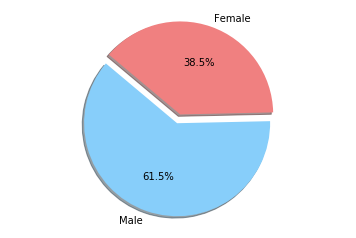

In [23]:
nb_clf = Pipeline([('vect', CountVectorizer(max_df=0.4)), ('clf', MultinomialNB(alpha=1.0))])
X_train, X_test, y_train, y_test = train_test_split(TextTweetsNew,data["gender"], test_size=0.20, shuffle = True)
nb_clf = nb_clf.fit(X_train, y_train.tolist())
prediction = nb_clf.predict(allTokenTweets)
male_count = np.count_nonzero(prediction == 'male')
female_count = np.count_nonzero(prediction == 'female')

# Data to plot
labels = 'Male', 'Female'
sizes = [male_count, female_count]
colors = [ 'lightskyblue','lightcoral']
explode = (0.1, 0)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()